# 1. Setup

## 1-1. Library Setup

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5405304689327497798
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11966789410920737214
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi

Tue Dec 14 02:10:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    375MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [ ]:
basemodel = 'DenseNet121'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 2
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1"
T_all_labels = "T0", "T1"

#base_path = ''
base_path = 'gdrive/My Drive/Research_1_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [ ]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_DenseNet121_None S_DenseNet121_imagenet T_DenseNet121_None T_DenseNet121_imagenet


['S_DenseNet121_imagenet',
 'S_DenseNet121_None',
 'T_DenseNet121_imagenet',
 'T_DenseNet121_None']

In [ ]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [ ]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [ ]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [ ]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [ ]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 2)
(480, 128, 128, 3) (480, 2)
(480, 128, 128, 3) (480, 2)

(1920, 128, 128, 3) (1920, 2)
(640, 128, 128, 3) (640, 2)
(640, 128, 128, 3) (640, 2)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


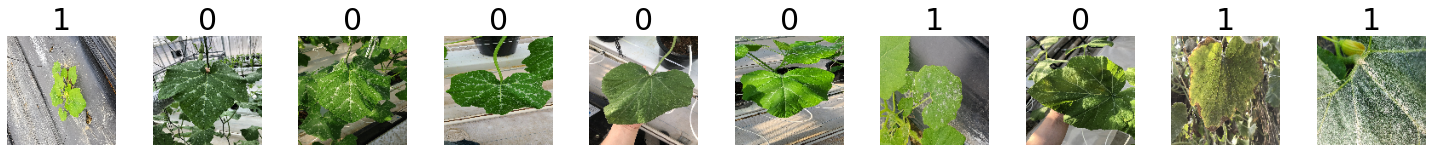

In [ ]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


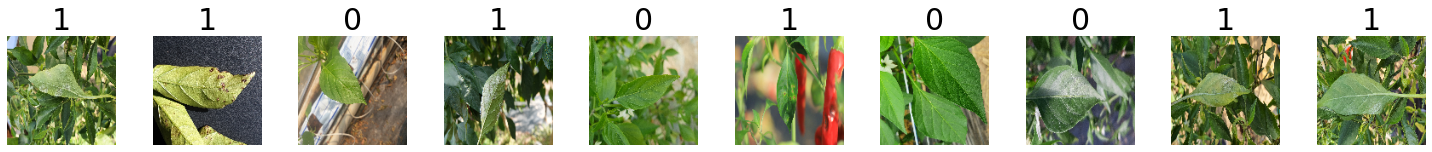

In [ ]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [ ]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [ ]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [ ]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [ ]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [ ]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 24s 274ms/step - loss: 0.2426 - accuracy: 0.8924 - val_loss: 1.2544 - val_accuracy: 0.4771
Epoch 2/100
23/23 [==============================] - 4s 154ms/step - loss: 0.1148 - accuracy: 0.9604 - val_loss: 2.1541 - val_accuracy: 0.5021
Epoch 3/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0565 - accuracy: 0.9826 - val_loss: 4.3952 - val_accuracy: 0.4604
Epoch 4/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0635 - accuracy: 0.9785 - val_loss: 10.4839 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0447 - accuracy: 0.9840 - val_loss: 6.0077 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 149ms/step - loss: 0.0223 - accuracy: 0.9917 - val_loss: 4.5980 - val_accuracy: 0.5021
Epoch 7/100
23/23 [==============================] - 4s 154ms/step - loss: 0.0416 - accuracy: 0.9875 - val_loss: 5.4634 - val_accuracy: 0.52

In [ ]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.242557,0.892361,1.254386,0.477083
1,0.114822,0.960417,2.154098,0.502083
2,0.056498,0.982639,4.395172,0.460417
3,0.063512,0.978472,10.483917,0.500000
4,0.044715,0.984028,6.007717,0.500000
...,...,...,...,...
75,0.009206,0.998611,0.098910,0.977083
76,0.002568,0.999306,0.069871,0.983333
77,0.002393,0.999306,0.571540,0.885417
78,0.002123,0.998611,0.493051,0.910417


Minimum validation loss: 0.044872354716062546
Maximum validation accuracy: 0.987500011920929


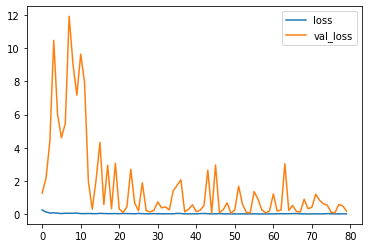

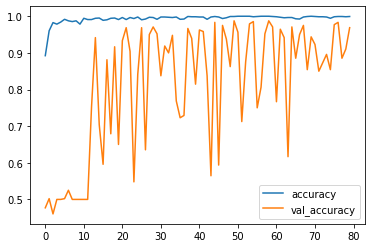

In [ ]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 2s 26ms/step - loss: 0.0438 - accuracy: 0.9917
test loss, test acc: [0.043843578547239304, 0.9916666746139526]


In [ ]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 2s 24ms/step


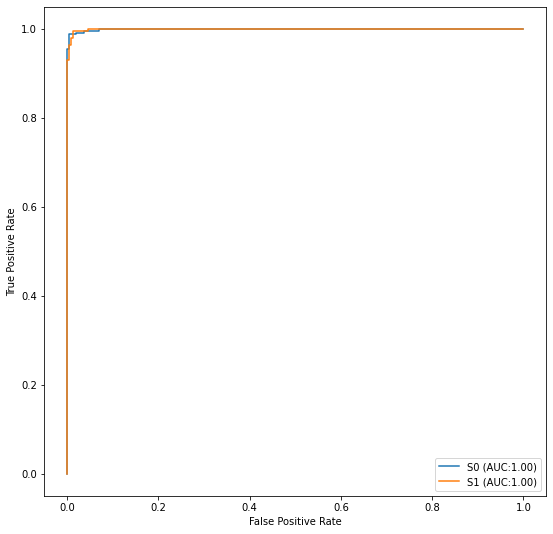

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [ ]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 15s 234ms/step - loss: 0.1359 - accuracy: 0.9479 - val_loss: 96.1192 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0624 - accuracy: 0.9785 - val_loss: 2.3026 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 4s 154ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 3.6240 - val_accuracy: 0.5188
Epoch 4/100
23/23 [==============================] - 4s 153ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 2.4772 - val_accuracy: 0.7417
Epoch 5/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 1.8474 - val_accuracy: 0.7417
Epoch 6/100
23/23 [==============================] - 4s 154ms/step - loss: 0.0259 - accuracy: 0.9896 - val_loss: 0.4443 - val_accuracy: 0.9396
Epoch 7/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0143 - accuracy: 0.9944 - val_loss: 4.0413 - val_accuracy: 0.68

In [ ]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.135870,0.947917,96.119179,0.500000
1,0.062371,0.978472,2.302637,0.500000
2,0.015686,0.995139,3.623958,0.518750
3,0.008915,0.997222,2.477220,0.741667
4,0.010622,0.995833,1.847421,0.741667
...,...,...,...,...
59,0.000002,1.000000,0.013256,0.997917
60,0.000004,1.000000,0.013311,0.995833
61,0.000004,1.000000,0.013407,0.995833
62,0.000002,1.000000,0.013310,0.995833


Minimum validation loss: 0.004402557387948036
Maximum validation accuracy: 0.9979166388511658


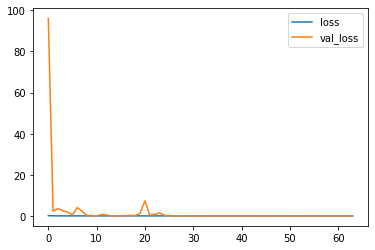

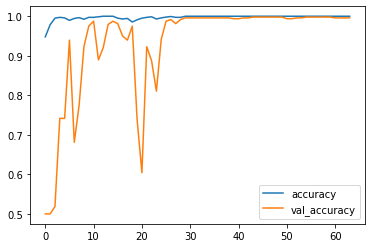

In [ ]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 2s 26ms/step - loss: 3.7446e-04 - accuracy: 1.0000
test loss, test acc: [0.00037446373607963324, 1.0]


In [ ]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 2s 24ms/step


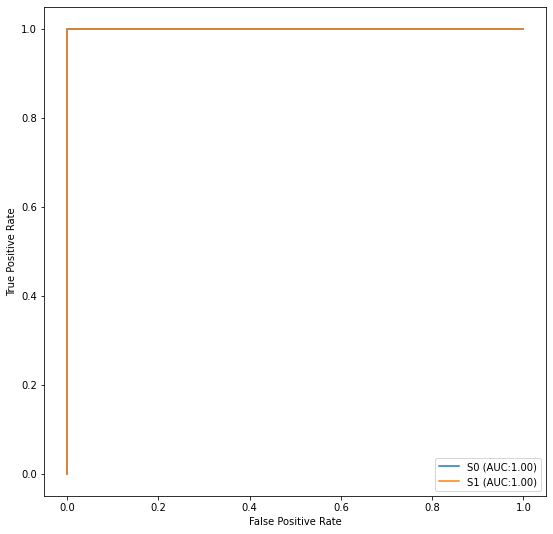

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [ ]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [ ]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 16s 214ms/step - loss: 0.3892 - accuracy: 0.8214 - val_loss: 0.7824 - val_accuracy: 0.4984
Epoch 2/100
30/30 [==============================] - 4s 148ms/step - loss: 0.2408 - accuracy: 0.9057 - val_loss: 0.8121 - val_accuracy: 0.4234
Epoch 3/100
30/30 [==============================] - 5s 153ms/step - loss: 0.2121 - accuracy: 0.9130 - val_loss: 0.6928 - val_accuracy: 0.5391
Epoch 4/100
30/30 [==============================] - 4s 149ms/step - loss: 0.2196 - accuracy: 0.9146 - val_loss: 0.7302 - val_accuracy: 0.5031
Epoch 5/100
30/30 [==============================] - 4s 149ms/step - loss: 0.1671 - accuracy: 0.9349 - val_loss: 1.8283 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 149ms/step - loss: 0.1241 - accuracy: 0.9521 - val_loss: 0.9277 - val_accuracy: 0.4844
Epoch 7/100
30/30 [==============================] - 4s 149ms/step - loss: 0.1123 - accuracy: 0.9568 - val_loss: 1.0010 - val_accuracy: 0.451

In [ ]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.389225,0.821354,0.782381,0.498437
1,0.240835,0.905729,0.812055,0.423438
2,0.212083,0.913021,0.692804,0.539062
3,0.219595,0.914583,0.730237,0.503125
4,0.167052,0.934896,1.828316,0.500000
5,0.124104,0.952083,0.927721,0.484375
6,0.112336,0.956771,1.000962,0.451562
7,0.096606,0.965625,2.680273,0.493750
8,0.099927,0.959375,1.631186,0.504687
9,0.101405,0.965104,0.828325,0.576563


Minimum validation loss: 0.3116428852081299
Maximum validation accuracy: 0.9078124761581421


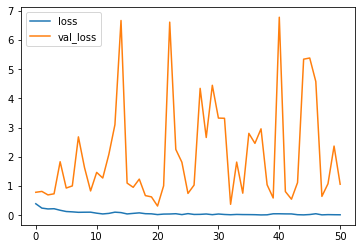

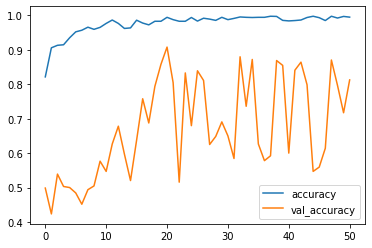

In [ ]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 2s 26ms/step - loss: 0.3684 - accuracy: 0.9187
test loss, test acc: [0.3683740198612213, 0.918749988079071]


In [ ]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 2s 24ms/step


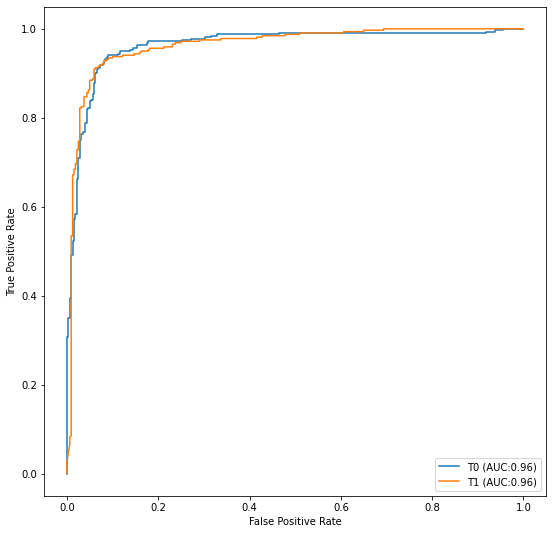

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [ ]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [ ]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 16s 216ms/step - loss: 0.1648 - accuracy: 0.9328 - val_loss: 5.3659 - val_accuracy: 0.5125
Epoch 2/100
30/30 [==============================] - 5s 154ms/step - loss: 0.0839 - accuracy: 0.9714 - val_loss: 4.0533 - val_accuracy: 0.7125
Epoch 3/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0522 - accuracy: 0.9797 - val_loss: 3.7487 - val_accuracy: 0.6953
Epoch 4/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0377 - accuracy: 0.9885 - val_loss: 1.9384 - val_accuracy: 0.7063
Epoch 5/100
30/30 [==============================] - 5s 153ms/step - loss: 0.0210 - accuracy: 0.9917 - val_loss: 1.4401 - val_accuracy: 0.8328
Epoch 6/100
30/30 [==============================] - 5s 154ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.7313 - val_accuracy: 0.8594
Epoch 7/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0139 - accuracy: 0.9943 - val_loss: 0.6608 - val_accuracy: 0.846

In [ ]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.164801,0.932813,5.365878,0.512500
1,0.083943,0.971354,4.053338,0.712500
2,0.052170,0.979688,3.748687,0.695312
3,0.037715,0.988542,1.938401,0.706250
4,0.021027,0.991667,1.440096,0.832812
5,0.021460,0.993229,0.731279,0.859375
6,0.013867,0.994271,0.660826,0.846875
7,0.040305,0.989583,0.231237,0.917188
8,0.017098,0.993750,4.267447,0.700000
9,0.019096,0.993750,1.944286,0.712500


Minimum validation loss: 0.020930271595716476
Maximum validation accuracy: 0.9921875


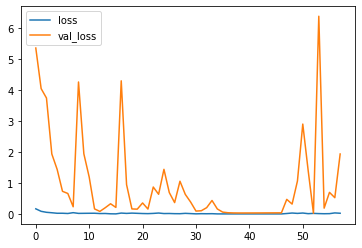

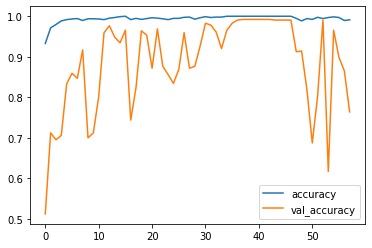

In [ ]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 2s 26ms/step - loss: 0.0597 - accuracy: 0.9906
test loss, test acc: [0.059657853096723557, 0.9906250238418579]


In [ ]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 2s 25ms/step


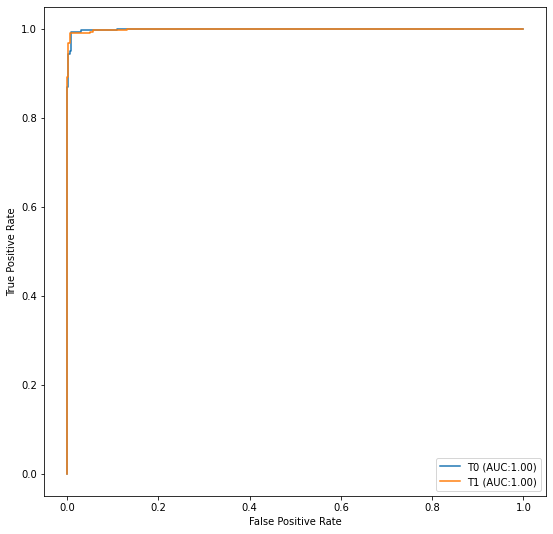

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [ ]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_DenseNet121_None
test loss, test acc: [0.043843578547239304, 0.9916666746139526]


In [ ]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_DenseNet121_imagenet
test loss, test acc: [0.00037446373607963324, 1.0]


In [ ]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_DenseNet121_None
test loss, test acc: [0.3683740198612213, 0.918749988079071]


In [ ]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_DenseNet121_imagenet
test loss, test acc: [0.059657853096723557, 0.9906250238418579]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [ ]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_DenseNet121_None →→→ Target Test
20/20 [==============================] - 1s 27ms/step - loss: 2.6868 - accuracy: 0.6250
test loss, test acc: [2.686849355697632, 0.625]


In [ ]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_DenseNet121_imagenet →→→ Target Test
20/20 [==============================] - 1s 27ms/step - loss: 2.2484 - accuracy: 0.6531
test loss, test acc: [2.2483720779418945, 0.653124988079071]


In [ ]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_DenseNet121_None →→→ Source Test
15/15 [==============================] - 0s 27ms/step - loss: 2.8163 - accuracy: 0.5042
test loss, test acc: [2.8162918090820312, 0.5041666626930237]


In [ ]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_DenseNet121_imagenet →→→ Source Test
15/15 [==============================] - 0s 26ms/step - loss: 2.0676 - accuracy: 0.6687
test loss, test acc: [2.0676357746124268, 0.668749988079071]


# 6. Model Save 

In [ ]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )